# Кредитный скоринг

В этом ноутбуке мы разберем некоторые темы feature engineering на примере датасета для задачи кредитного скоринга.

Для этой задачи есть [учебное соревнование на Kaggle](https://www.kaggle.com/competitions/bank-issues-042022/leaderboard). Вы можете отправлять в него свои решения.

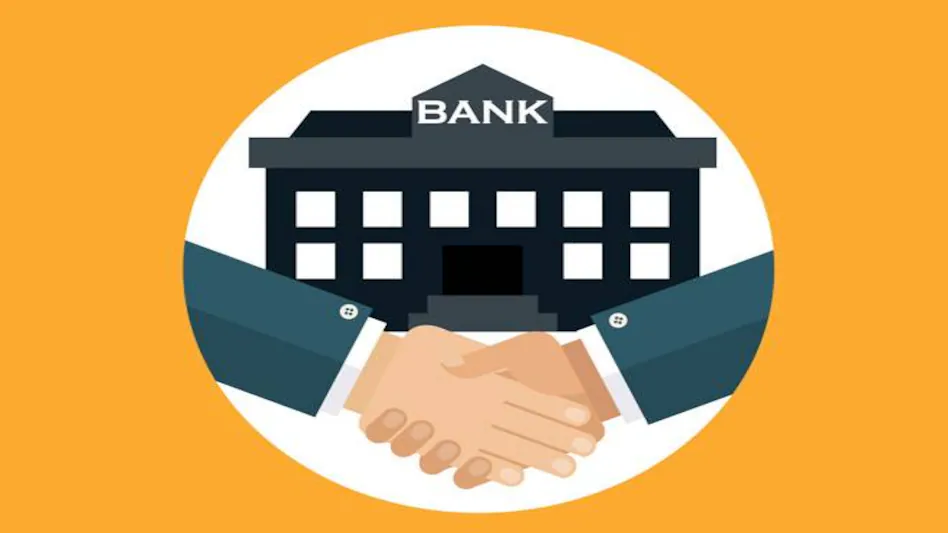

## Скачивание данных

Скачаем данные и импортируем нужные библиотеки

In [3]:
! pip install wldhx.yadisk-direct
! curl -L $(yadisk-direct https://disk.yandex.com/d/sknuSa3xoNBsDw) -o bank-issues-data.zip


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3473k  100 3473k    0     0  8070k      0 --:--:-- --:--:-- --:--:-- 8070k


In [4]:
! unzip -qq bank-issues-data.zip

replace __MACOSX/._bank-issues-data? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

OSError: [Errno 5] Input/output error

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Обработка тренировочных данных

In [186]:
train_data = pd.read_csv('./bank-issues-data/train.csv')
test_data = pd.read_csv('./bank-issues-data/test.csv')

In [187]:
train_data.head()

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,1,M,25,UNM,SPC,26389.0,10,1.32,0.584105,SCH,ОБЛ КУРСКАЯ,35000.0,2.0,0.0,1
1,2,F,37,MAR,SPC,19588.0,12,1.43,0.718935,SCH,РЕСПУБЛИКА ТАТАРСТАН,15000.0,0.0,0.0,1
2,3,F,28,UNM,SPC,53669.0,18,1.10,0.586015,GRD,МОСКВА Г,70000.0,4.0,0.0,1
3,4,M,34,MAR,SPC,26349.0,10,1.43,0.655703,SCH,СВЕРДЛОВСКАЯ ОБЛАСТЬ,42500.0,4.0,0.0,0
4,5,F,43,MAR,UMN,11589.0,10,1.10,0.271893,GRD,РЯЗАНСКАЯ ОБЛАСТЬ,20000.0,3.0,0.0,0


Поля данных:
- **client_id** — Уникальный идентификатор клиента
- **gender** — Пол
- **age** — Возраст (в годах)
- **marital_status** — Семейное положение.
    Возможные значения:
    - UNM : Холост/не замужем
    - DIV : Резведен (а)
    - MAR : Женат/замужем
    - WID : Вдовец, вдова
    - CIV : Гражданский брак
- **job_position** — Работа.
    Возможные значения:
    - SPC : Неруководящий сотрудник - специалист
    - DIR : Руководитель организации
    - HSK : Домохозяйка
    - WOI : Работает на ИП
    - WRK : Неруководящий сотрудник - рабочий
    - ATP : Неруководящий сотрудник - обслуживающий персонал
    - WRP : Работающий пенсионер
    - UMN : Руководитель подразделения
    - NOR : Не работает
    - NS : Пенсионер
    - BIS : Собственный бизнес
    - INP : Индивидуальный предприниматель
- **credit_sum** — Сумма кредита
- **credit_month** — Срок кредитования в месяцах
- **tariff_id** — Номер предлагаемого тарифа
- **education** — Тип образования.
    Возможные знаяения:
    - SCH : Начальное, среднее
    - PGR : Второе высшее
    - GRD : Высшее
    - UGR : Неполное высшее
    - ACD : Ученая степень
- **living_region** — Регион проживания
- **monthly_income** — Зарплата в месяц
- **credit_count** — Количество кредитов у клиента
- **overdue_credit_count** — Количество просроченных кредитов клиента
- **open_account_flag** — Целевая переменная -- выберет клиент наш банк или нет

Отделим целевую переменную от признаков:

In [188]:
y_train = train_data['open_account_flg']
train_data = train_data.drop(columns=['open_account_flg'])

In [189]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119518 entries, 0 to 119517
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   client_id             119518 non-null  int64  
 1   gender                119518 non-null  object 
 2   age                   119518 non-null  int64  
 3   marital_status        119518 non-null  object 
 4   job_position          119518 non-null  object 
 5   credit_sum            119518 non-null  float64
 6   credit_month          119518 non-null  int64  
 7   tariff_id             119518 non-null  float64
 8   score_shk             119518 non-null  float64
 9   education             119518 non-null  object 
 10  living_region         119385 non-null  object 
 11  monthly_income        119518 non-null  float64
 12  credit_count          113032 non-null  float64
 13  overdue_credit_count  113032 non-null  float64
dtypes: float64(6), int64(3), object(5)
memory usage: 12.

### Заполнение пропусков

Еще раз выведем то, как выглядят тренировочные данные для удобства

In [190]:
train_data.head()

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count
0,1,M,25,UNM,SPC,26389.0,10,1.32,0.584105,SCH,ОБЛ КУРСКАЯ,35000.0,2.0,0.0
1,2,F,37,MAR,SPC,19588.0,12,1.43,0.718935,SCH,РЕСПУБЛИКА ТАТАРСТАН,15000.0,0.0,0.0
2,3,F,28,UNM,SPC,53669.0,18,1.10,0.586015,GRD,МОСКВА Г,70000.0,4.0,0.0
3,4,M,34,MAR,SPC,26349.0,10,1.43,0.655703,SCH,СВЕРДЛОВСКАЯ ОБЛАСТЬ,42500.0,4.0,0.0
4,5,F,43,MAR,UMN,11589.0,10,1.10,0.271893,GRD,РЯЗАНСКАЯ ОБЛАСТЬ,20000.0,3.0,0.0


Посмотрим, в каких колонках есть пропуски в тренировочных данных

In [191]:
train_data.isna().any()

client_id               False
gender                  False
age                     False
marital_status          False
job_position            False
credit_sum              False
credit_month            False
tariff_id               False
score_shk               False
education               False
living_region            True
monthly_income          False
credit_count             True
overdue_credit_count     True
dtype: bool

Посмотрим также, какие пропуски есть в тестовых данных:

In [192]:
test_data.isna().any()

client_id               False
gender                  False
age                     False
marital_status          False
job_position            False
credit_sum              False
credit_month            False
tariff_id               False
score_shk               False
education               False
living_region            True
monthly_income           True
credit_count             True
overdue_credit_count     True
dtype: bool

Видим, что в тестовой части есть пропуски в колонке monthly_income, а в тренировочной части в ней пропусков нет. Нам нужно будет понять, как мы будем заполнять пропуски в этой колонке.

**Внимание**: важно помнить, что иногда в данных бывают пропуски, которые pandas не ловит. Например, когда пропуск в категориальной колонке "job_position", и выражается он тем, что вместо значения стоит пустая строка '' или пробел ' '. Такое pandas не отловит.

**Как можно заполнять пропуски в колонках?**



#### Варианты заполнения пропусков

- Заполнить пропуски некоторой статистикой по данным (среднее/медиана/0/...). Поможет [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) из Sklearn;

    **Вопрос**: почему медиана предпочтительнее среднего?

- Использовать более сложные стратегии. Например, [IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer) или  [KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html);

- Добавить значение "пропуск" на место пропусков. Поможет [MissingIndicator](https://scikit-learn.org/stable/modules/generated/sklearn.impute.MissingIndicator.html#sklearn.impute.MissingIndicator) из Sklearn;
- А иногда вообще бывает так, что из тренировочных данных лучше удалить строки, где много пропусков. Логика такая: если об объекте известно мало, то полезной информации для модели этот объект не несет. Обратите внимание, что из тестовых данных никакие строки удалять нельзя!
- Вообще удалить признак с пропусками. Может быть логично, если пропусков слишком много;

#### Заполнение пропусков в наших данных

Посмотрим, сколько пропущенных значений в колонках credit_count и overdue_credit_count:

In [193]:
train_data['credit_count'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 119518 entries, 0 to 119517
Series name: credit_count
Non-Null Count   Dtype  
--------------   -----  
113032 non-null  float64
dtypes: float64(1)
memory usage: 933.9 KB


In [194]:
np.unique(train_data['credit_count'], return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., nan]),
 array([18219, 31714, 25799, 16707,  9826,  5285,  2760,  1345,   707,
          326,   141,    90,    56,    25,    12,    10,     2,     4,
            1,     3,  6486]))

Заполним пропуск в credit_count медианой:

In [195]:
# заполнение пропусков статистикой вручную

# median_value_credit_count = np.median(train_data['credit_count'].dropna())
# train_data['credit_count'].fillna(median_value_credit_count)

In [196]:
from sklearn.impute import SimpleImputer

simple_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
simple_imputer.fit(train_data[['credit_count']])
train_data['credit_count'] = simple_imputer.transform(train_data[['credit_count']])

In [197]:
train_data['credit_count'].isna().any()

np.False_

Заполним пропуск в overdue_credit_count с помощью KNNImputer:

In [198]:
train_data['job_position'].dtype

dtype('O')

dtype('O') означает object. Вычислим все числовые колонки (int, float), к ним можно применить knn_imputer

In [199]:
numeric_columns = [column for column in train_data.columns if train_data[column].dtype != 'O']
numeric_columns

['client_id',
 'age',
 'credit_sum',
 'credit_month',
 'tariff_id',
 'score_shk',
 'monthly_income',
 'credit_count',
 'overdue_credit_count']

In [200]:
numeric_columns.remove("tariff_id")

In [201]:
len(numeric_columns)

8

In [202]:
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=2)
knn_imputer.fit(train_data[numeric_columns])
transformed_overdue_credit_count = knn_imputer.transform(train_data[numeric_columns])
train_data['overdue_credit_count'] = transformed_overdue_credit_count

In [203]:
train_data['overdue_credit_count'].isna().any()

np.False_

TODO: заполнить пропуски в оставшихся признаках

### Обработка категориальных признаков

In [204]:
train_data.head()

,client_id,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count
0,1,M,25,UNM,SPC,26389.0,10,1.32,0.584105,SCH,ОБЛ КУРСКАЯ,35000.0,2.0,1.0
1,2,F,37,MAR,SPC,19588.0,12,1.43,0.718935,SCH,РЕСПУБЛИКА ТАТАРСТАН,15000.0,0.0,2.0
2,3,F,28,UNM,SPC,53669.0,18,1.10,0.586015,GRD,МОСКВА Г,70000.0,4.0,3.0
3,4,M,34,MAR,SPC,26349.0,10,1.43,0.655703,SCH,СВЕРДЛОВСКАЯ ОБЛАСТЬ,42500.0,4.0,4.0
4,5,F,43,MAR,UMN,11589.0,10,1.10,0.271893,GRD,РЯЗАНСКАЯ ОБЛАСТЬ,20000.0,3.0,5.0


In [205]:
categorical_columns = [column for column in train_data.columns if train_data[column].dtype == 'O']
categorical_columns

['gender', 'marital_status', 'job_position', 'education', 'living_region']

In [206]:
categorical_columns = categorical_columns + ['tariff_id']

In [207]:
categorical_columns = [x for x in categorical_columns if x != 'living_region']

In [208]:
np.unique(train_data['marital_status'])

array(['CIV', 'DIV', 'MAR', 'UNM', 'WID'], dtype=object)

#### One-hot кодирование

In [209]:
dummy_features = pd.get_dummies(train_data['marital_status'])
dummy_features.head()

,CIV,DIV,MAR,UNM,WID
0,False,False,False,True,False
1,False,False,True,False,False
2,False,False,False,True,False
3,False,False,True,False,False
4,False,False,True,False,False


One-hot кодирование с помощью OneHotEncoder из Sklearn

In [210]:
categorical_columns

['gender', 'marital_status', 'job_position', 'education', 'tariff_id']

In [211]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(drop='if_binary', sparse_output=False) #drop='if_binary' - для бинарного признака удаляем одну колонку
ohe.fit(train_data[categorical_columns])
new_category_columns = ohe.transform(train_data[categorical_columns])

In [212]:
new_category_columns

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], shape=(119518, 59))

In [214]:
ohe.get_feature_names_out()

array(['gender_M', 'marital_status_CIV', 'marital_status_DIV',
       'marital_status_MAR', 'marital_status_UNM', 'marital_status_WID',
       'job_position_ATP', 'job_position_BIS', 'job_position_BIU',
       'job_position_DIR', 'job_position_HSK', 'job_position_INP',
       'job_position_NOR', 'job_position_PNA', 'job_position_PNI',
       'job_position_PNS', 'job_position_PNV', 'job_position_SPC',
       'job_position_UMN', 'job_position_WOI', 'job_position_WRK',
       'job_position_WRP', 'education_ACD', 'education_GRD',
       'education_PGR', 'education_SCH', 'education_UGR', 'tariff_id_1.0',
       'tariff_id_1.1', 'tariff_id_1.16', 'tariff_id_1.17',
       'tariff_id_1.18', 'tariff_id_1.19', 'tariff_id_1.2',
       'tariff_id_1.21', 'tariff_id_1.22', 'tariff_id_1.23',
       'tariff_id_1.24', 'tariff_id_1.25', 'tariff_id_1.26',
       'tariff_id_1.27', 'tariff_id_1.28', 'tariff_id_1.29',
       'tariff_id_1.3', 'tariff_id_1.32', 'tariff_id_1.4',
       'tariff_id_1.41', 'tarif

In [215]:
new_train_columns = pd.DataFrame(new_category_columns, columns=ohe.get_feature_names_out())
train_data = train_data.drop(columns=categorical_columns)
train_data = pd.concat([train_data, new_train_columns], axis=1)
train_data.head()

,client_id,age,credit_sum,credit_month,score_shk,living_region,monthly_income,credit_count,overdue_credit_count,gender_M,...,tariff_id_1.48,tariff_id_1.5,tariff_id_1.52,tariff_id_1.56,tariff_id_1.6,tariff_id_1.7,tariff_id_1.9,tariff_id_1.91,tariff_id_1.94,tariff_id_1.96
0,1,25,26389.0,10,0.584105,ОБЛ КУРСКАЯ,35000.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,37,19588.0,12,0.718935,РЕСПУБЛИКА ТАТАРСТАН,15000.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,28,53669.0,18,0.586015,МОСКВА Г,70000.0,4.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,34,26349.0,10,0.655703,СВЕРДЛОВСКАЯ ОБЛАСТЬ,42500.0,4.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,43,11589.0,10,0.271893,РЯЗАНСКАЯ ОБЛАСТЬ,20000.0,3.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Что делать если в тестовых данных появилась новая категория, которой не было в тренировочных данных?

Модель может работать только на тех категориях на которых она обучалась, придется поставить везде нули при кодировании one-hot

#### Обработка living_region

In [216]:
np.unique(train_data['living_region'].dropna(), return_counts=True)

(array(['74', '98', 'АДЫГЕЯ РЕСП', 'АЛТАЙСКИЙ', 'АЛТАЙСКИЙ КРАЙ',
        'АМУРСКАЯ ОБЛ', 'АМУРСКАЯ ОБЛАСТЬ', 'АО НЕНЕЦКИЙ',
        'АО ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - Ю', 'АО ЯМАЛО-НЕНЕЦКИЙ',
        'АОБЛ ЕВРЕЙСКАЯ', 'АРХАНГЕЛЬСКАЯ', 'АРХАНГЕЛЬСКАЯ ОБЛ',
        'АРХАНГЕЛЬСКАЯ ОБЛАСТЬ', 'АСТРАХАНСКАЯ', 'АСТРАХАНСКАЯ ОБЛ',
        'АСТРАХАНСКАЯ ОБЛАСТЬ', 'БАШКОРТОСТАН', 'БАШКОРТОСТАН РЕСП',
        'БЕЛГОРОДСКАЯ ОБЛ', 'БЕЛГОРОДСКАЯ ОБЛАСТЬ', 'БРЯНСКАЯ ОБЛ',
        'БРЯНСКАЯ ОБЛАСТЬ', 'БРЯНСКИЙ', 'БУРЯТИЯ', 'БУРЯТИЯ РЕСП',
        'ВЛАДИМИРСКАЯ ОБЛ', 'ВЛАДИМИРСКАЯ ОБЛАСТЬ', 'ВОЛГОГРАДСКАЯ ОБЛ',
        'ВОЛГОГРАДСКАЯ ОБЛАСТЬ', 'ВОЛОГОДСКАЯ', 'ВОЛОГОДСКАЯ ОБЛ',
        'ВОЛОГОДСКАЯ ОБЛ.', 'ВОЛОГОДСКАЯ ОБЛАСТЬ', 'ВОРОНЕЖСКАЯ ОБЛ',
        'ВОРОНЕЖСКАЯ ОБЛАСТЬ', 'Г МОСКВА', 'Г. МОСКВА',
        'Г. САНКТ-ПЕТЕРБУРГ', 'Г.МОСКВА', 'ГОРЬКОВСКАЯ ОБЛ',
        'ГУСЬ-ХРУСТАЛЬНЫЙ Р-Н', 'ДАГЕСТАН РЕСП', 'ЕВРЕЙСКАЯ АВТОНОМНАЯ',
        'ЕВРЕЙСКАЯ АОБЛ', 'ЗАБАЙКАЛЬСКИЙ КРАЙ', 'ИВАНОВСКАЯ ОБЛ',

In [217]:
places = np.unique(train_data['living_region'].dropna())
places

array(['74', '98', 'АДЫГЕЯ РЕСП', 'АЛТАЙСКИЙ', 'АЛТАЙСКИЙ КРАЙ',
       'АМУРСКАЯ ОБЛ', 'АМУРСКАЯ ОБЛАСТЬ', 'АО НЕНЕЦКИЙ',
       'АО ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - Ю', 'АО ЯМАЛО-НЕНЕЦКИЙ',
       'АОБЛ ЕВРЕЙСКАЯ', 'АРХАНГЕЛЬСКАЯ', 'АРХАНГЕЛЬСКАЯ ОБЛ',
       'АРХАНГЕЛЬСКАЯ ОБЛАСТЬ', 'АСТРАХАНСКАЯ', 'АСТРАХАНСКАЯ ОБЛ',
       'АСТРАХАНСКАЯ ОБЛАСТЬ', 'БАШКОРТОСТАН', 'БАШКОРТОСТАН РЕСП',
       'БЕЛГОРОДСКАЯ ОБЛ', 'БЕЛГОРОДСКАЯ ОБЛАСТЬ', 'БРЯНСКАЯ ОБЛ',
       'БРЯНСКАЯ ОБЛАСТЬ', 'БРЯНСКИЙ', 'БУРЯТИЯ', 'БУРЯТИЯ РЕСП',
       'ВЛАДИМИРСКАЯ ОБЛ', 'ВЛАДИМИРСКАЯ ОБЛАСТЬ', 'ВОЛГОГРАДСКАЯ ОБЛ',
       'ВОЛГОГРАДСКАЯ ОБЛАСТЬ', 'ВОЛОГОДСКАЯ', 'ВОЛОГОДСКАЯ ОБЛ',
       'ВОЛОГОДСКАЯ ОБЛ.', 'ВОЛОГОДСКАЯ ОБЛАСТЬ', 'ВОРОНЕЖСКАЯ ОБЛ',
       'ВОРОНЕЖСКАЯ ОБЛАСТЬ', 'Г МОСКВА', 'Г. МОСКВА',
       'Г. САНКТ-ПЕТЕРБУРГ', 'Г.МОСКВА', 'ГОРЬКОВСКАЯ ОБЛ',
       'ГУСЬ-ХРУСТАЛЬНЫЙ Р-Н', 'ДАГЕСТАН РЕСП', 'ЕВРЕЙСКАЯ АВТОНОМНАЯ',
       'ЕВРЕЙСКАЯ АОБЛ', 'ЗАБАЙКАЛЬСКИЙ КРАЙ', 'ИВАНОВСКАЯ ОБЛ',
       'ИВАНОВ

In [218]:
import re
def clean_place_name(name):
    patterns = [
        r'^((г|д|п|с|гор|р-н|дер|пос|обл|об|кр|окр|респ|ао|аобл|аокр)\.\s*|(г|д|п|с|гор|р-н|дер|пос|обл|об|кр|окр|респ|ао|аобл|аокрс)\s+)',   # г., г, гор., гор
        #r'^гор\.?\s*',         # гор., гор
        r'(\s+|^)(город|поселок|деревня|село|район|область|край|республика|округ)\.?\s*',          # город
        r'^пгт\.?\s*',         # пгт., пгт
        r'^г\.о\.?\s*',        # г.о., го
        r'^м\.о\.?\s*',        # м.о., мо
        r'муниципальный|муниципальная|автономный|автономная|городской|городского|федеральный|федеральная',  # муниципальный район
        r'(\s+|^)[а-я]\.\s+',
        r'\s+[а-я]\.\s*$',
        r'(^|\s+)([а-я]\.)+',
        r'\s+[а-я]$',
        r'\s+(город|поселок|деревня|село|район|область|край|республика|округ|г|д|п|с|гор|р-н|дер|пос|обл|об|кр|окр|респ|ао|аобл|аокр)\.*$',
    ]
    
    # Объединяем все паттерны через |
    full_pattern = '|'.join(patterns)
    
    # Удаляем приписку из начала строки
    cleaned = re.sub(full_pattern, '', name, flags=re.IGNORECASE)
    
    return cleaned.strip()

In [219]:
def tokenize_living_region_best(series):
    series = series.copy()
    hard_names = ['ХАНТЫМАНСИЙСК', 'ЧУВАШ', 'АЛАНИЯ', 'ЯКУТИЯ']
    
    def transform(val):

        if pd.isna(val):
            return val
        
        cleaned = clean_place_name(val)
        cleaned = re.sub(r'[^а-яё0-9]+|(ая|ий|ый)$', '', cleaned, flags=re.IGNORECASE)
        
        cleaned_upper = cleaned.upper()
        for name in hard_names:
            if name in cleaned_upper:
                return name
        
        return cleaned
    
    return series.apply(transform)

train_data['living_region'] = tokenize_living_region_best(train_data['living_region'])
print(train_data['living_region'].value_counts())

test_data['living_region'] = tokenize_living_region_best(test_data['living_region'])
print(test_data['living_region'].value_counts())

living_region
МОСКОВСК          8992
МОСКВА            6391
САНКТПЕТЕРБУРГ    5857
КРАСНОДАРСК       5798
ТАТАРСТАН         5372
                  ... 
МЫТИЩИНСК            1
74                   1
ПРИВОЛЖСК            1
98                   1
ОРЁЛ                 1
Name: count, Length: 92, dtype: int64
living_region
МОСКОВСК            3844
МОСКВА              2870
КРАСНОДАРСК         2557
САНКТПЕТЕРБУРГ      2444
ТАТАРСТАН           2295
                    ... 
ЭВЕНКИЙСК              1
МОСКВОСК               1
САХА                   1
ДАЛЬНИЙВОСТОК          1
ОДИНЦОВОМОСКОВСК       1
Name: count, Length: 91, dtype: int64


Можно скачать таблицу номеров регионов и добавить предобработку номеров

Также можно токенизировать полученные названия

Какие проблемы тут есть или могут возникнуть:

- Один и тот же регион написан по-разному;
- Есть регионы, которые встречаются очень редко; (Можно объединить категории которые встречаются очень редко в одну категорию)
- Возможны два типа ситуаций:
    - Какой-то регион есть в тренировочных данных, но его нет в тестовых; (ничего страшного, ничего не делаем)
    - Какой-то регион есть в тестовых данных, но его нет в тренировочных. (тестовые данные должны быть обработаны так же как и тренировочные, поэтому при кодировании one-hot для тестовых данных мы должны поставить нули для всех регионов, которые были в тренировочных данных, а для нового региона, которого не было в тренировочных данных, мы также должны поставить нули)

**Задание**: обработайте признак living_region. Не забудьте, что в тестовых данных вам нужно будет обработать этот признак в той же манере, что и в тренировочных данных.

In [ ]:
def combine_rare_regions(df, column, threshold=10, new_name='ДРУГОЙ'):
    df = df.copy()
    counts = df[column].value_counts()
    rare_regions = counts[counts < threshold].index
    df[column] = df[column].apply(
        lambda x: new_name if x in rare_regions else x
    )    
    return df, rare_regions

train_data, rare_regions = combine_rare_regions(train_data, 'living_region', threshold=100)
print(train_data['living_region'].value_counts())

living_region
МОСКОВСК          8992
МОСКВА            6391
САНКТПЕТЕРБУРГ    5857
КРАСНОДАРСК       5798
ТАТАРСТАН         5372
                  ... 
КАЛМЫКИЯ           203
ДРУГОЙ             174
ЕВРЕЙСК            139
НЕНЕЦК             113
МАГАДАНСК          107
Name: count, Length: 79, dtype: int64
living_region
МОСКОВСК            3844
МОСКВА              2870
КРАСНОДАРСК         2557
САНКТПЕТЕРБУРГ      2444
ТАТАРСТАН           2295
                    ... 
ЭВЕНКИЙСК              1
МОСКВОСК               1
САХА                   1
ДАЛЬНИЙВОСТОК          1
ОДИНЦОВОМОСКОВСК       1
Name: count, Length: 84, dtype: int64


In [ ]:
# Для тестовых данных мы должны объединить те же самые регионы, которые были объединены в тренировочных данных
#test_data['living_region'] = test_data['living_region'].apply(
#    lambda x: 'ДРУГОЙ' if x in rare_regions else x
#)
#print(test_data['living_region'].value_counts())

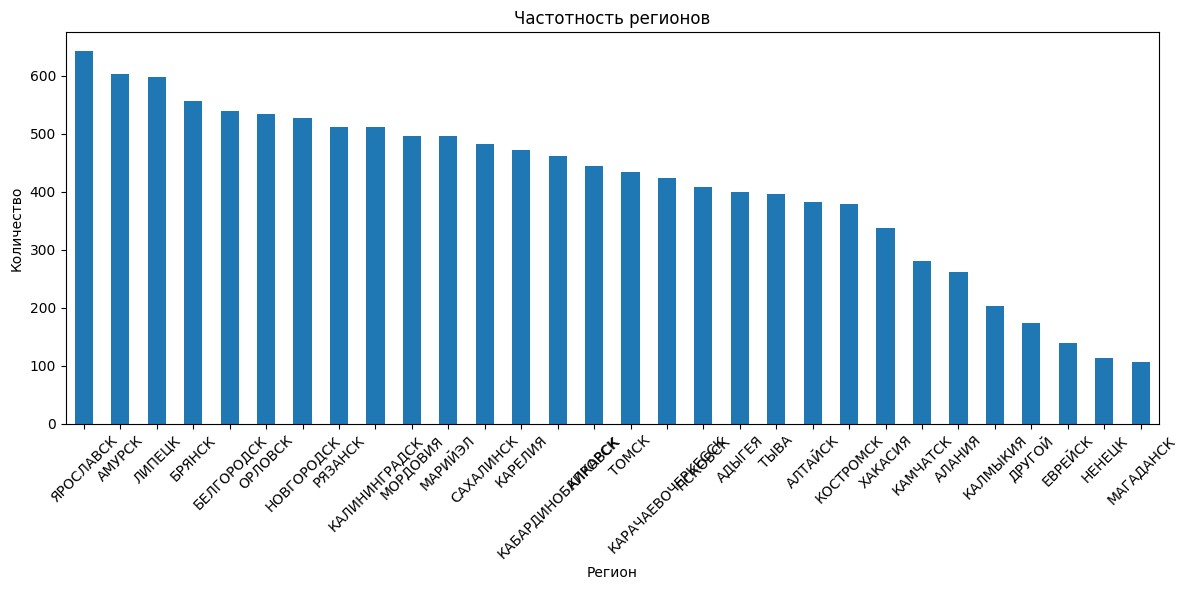

In [221]:
region_counts = train_data['living_region'].value_counts()

plt.figure(figsize=(12, 6))
region_counts.tail(30).plot(kind='bar')
plt.title('Частотность регионов')
plt.xlabel('Регион')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

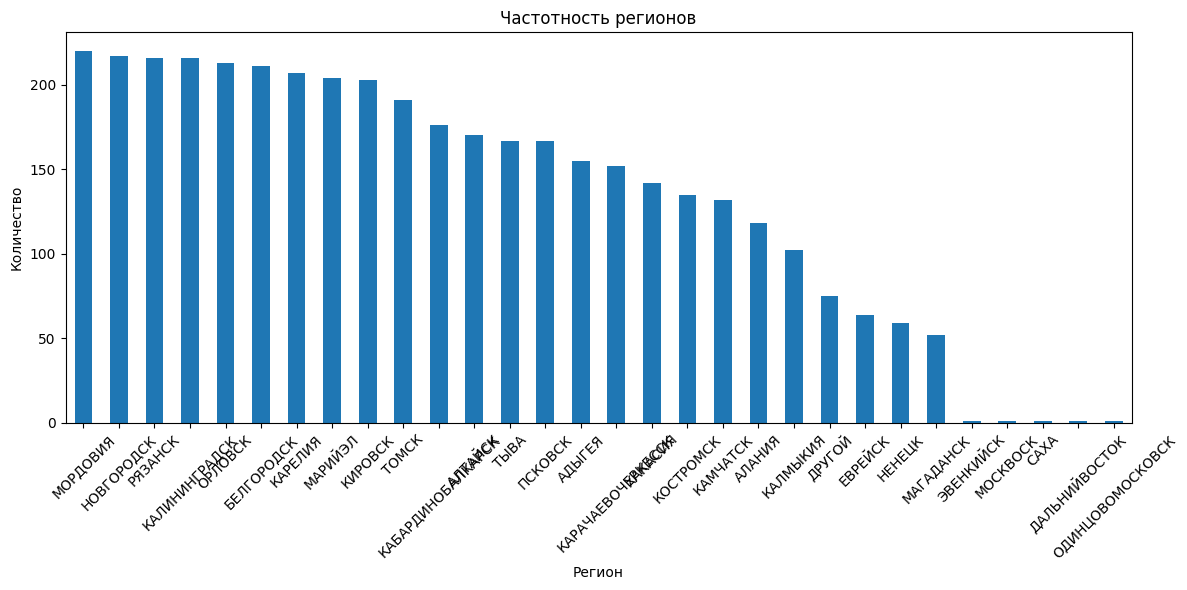

In [222]:
region_counts = test_data['living_region'].value_counts()

plt.figure(figsize=(12, 6))
region_counts.tail(30).plot(kind='bar')
plt.title('Частотность регионов')
plt.xlabel('Регион')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [223]:
%pip install category_encoders


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# кодируем ТОЛЬКО колонку living_region
encoder = ce.BinaryEncoder(
    cols=['living_region'], 
    handle_unknown='value',
    handle_missing='value'
)

# Fit только на одной колонке
encoder.fit(train_data[['living_region']])

# Transform для train и test
train_encoded_col = encoder.transform(train_data[['living_region']])
test_encoded_col = encoder.transform(test_data[['living_region']])

# Добавляем закодированные колонки обратно в исходные данные
train_encoded = train_data.copy()
test_encoded = test_data.copy()

# Удаляем исходную колонку и добавляем закодированные
train_encoded = pd.concat([
    train_encoded.drop('living_region', axis=1), 
    train_encoded_col
], axis=1)

test_encoded = pd.concat([
    test_encoded.drop('living_region', axis=1), 
    test_encoded_col
], axis=1)

In [ ]:
#Используем бинарное кодирование для признака living_region
import category_encoders as ce

# СОЗДАЕМ И ОБУЧАЕМ ЭНКОДЕР ТОЛЬКО НА ТРЕНИРОВОЧНЫХ ДАННЫХ
encoder = ce.BinaryEncoder(
    cols=['living_region'], 
    handle_unknown='value',  # новые категории получат [0,0,0,...]
    handle_missing='value'   # пропуски тоже получат 0
)

# Fit только на train
encoder.fit(train_data[['living_region']]) # Важно: передаем DataFrame с одной колонкой!

# Transform для train и test
train_encoded_col = encoder.transform(train_data[['living_region']])
test_encoded_col = encoder.transform(test_data[['living_region']])

train_encoded = train_data.copy()
test_encoded = test_data.copy()

train_encoded = pd.concat([
    train_encoded.drop('living_region', axis=1), 
    train_encoded_col
], axis=1)

test_encoded = pd.concat([
    test_encoded.drop('living_region', axis=1), 
    test_encoded_col
])

In [228]:
train_encoded.head()

,client_id,age,credit_sum,credit_month,score_shk,monthly_income,credit_count,overdue_credit_count,gender_M,marital_status_CIV,...,tariff_id_1.91,tariff_id_1.94,tariff_id_1.96,living_region_0,living_region_1,living_region_2,living_region_3,living_region_4,living_region_5,living_region_6
0,1,25,26389.0,10,0.584105,35000.0,2.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,1
1,2,37,19588.0,12,0.718935,15000.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,1,0
2,3,28,53669.0,18,0.586015,70000.0,4.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,1,1
3,4,34,26349.0,10,0.655703,42500.0,4.0,4.0,1.0,0.0,...,0.0,0.0,0.0,0,0,0,0,1,0,0
4,5,43,11589.0,10,0.271893,20000.0,3.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,1,0,1


TODO

Написать пайплайн для предобработки признаков. В пайплайне должны быть следующие шаги:
- Заполнение пропусков в колонках credit_count и overdue_credit_count;
- Кодирование категориальных признаков с помощью one-hot кодирования;
- Обработка признака living_region;
- ...

Все шаги должны быть применены точно также как для тренировочных данных и в той же последовательности.

Также из этого признака можно создать новые признаки:
- какие?

Можно найти статистику по регионам и добавить ее в виде новых признаков. Например, можно найти средний доход по каждому региону и добавить его в виде нового признака. Или можно поделить сумму кредита на срок и получить новый признак "ежемесячный платеж", который можно сравнить с ежемесячным доходом.

### Создание новых признаков

#### Ручное создание новых признаков

In [174]:
train_data.head()

,client_id,age,credit_sum,credit_month,score_shk,living_region,monthly_income,credit_count,overdue_credit_count,gender_M,...,tariff_id_1.48,tariff_id_1.5,tariff_id_1.52,tariff_id_1.56,tariff_id_1.6,tariff_id_1.7,tariff_id_1.9,tariff_id_1.91,tariff_id_1.94,tariff_id_1.96
0,1,25,26389.0,10,0.584105,КУРСК,35000.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,37,19588.0,12,0.718935,ТАТАРСТАН,15000.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,28,53669.0,18,0.586015,МОСКВА,70000.0,4.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,34,26349.0,10,0.655703,СВЕРДЛОВСК,42500.0,4.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,43,11589.0,10,0.271893,РЯЗАНСК,20000.0,3.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Часто на основе имеющихся признаков можно создавать новые. Какие новые признаки приходят на ум для нашего датасета?

#### Автоматическое создание новых признаков

Помогут [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) из sklearn

Генерируем кучу признаков. Обучаем слабую модель на всех этих признаках, смотрим какие признаки имеют наибольший смысл, и отбрасываем лишние.

In [175]:
numeric_columns.remove('tariff_id')

ValueError: list.remove(x): x not in list

In [ ]:
train_data[numeric_columns]

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
# сначала нужно заполнить пропуски в данных
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(train_data[numeric_columns])
X_test_poly = poly.fit_transform(test_data[numeric_columns])

In [ ]:
print("\nПолиномиальные признаки (x, x²):\n", X_poly)

In [ ]:
print("\nНазвания признаков:", poly.get_feature_names_out(numeric_columns))

In [ ]:
train_data[numeric_columns]

In [ ]:
X_poly.shape

### Фильтрация признаков

Помогут [SequentialFeatureSelector](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#sklearn.feature_selection.SequentialFeatureSelector), [SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel) и другие классы из модуля [feature_selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection) sklearn.

TODO: сделать фильтрацию признаков

## Обработка тестовых данных

In [ ]:
test_data.head()

Заполнение пропусков в данных:

In [ ]:
test_data['credit_count'] = simple_imputer.transform(test_data[['credit_count']])
transformed_test_data = knn_imputer.transform(test_data[numeric_columns])[:, 8]
test_data['overdue_credit_count'] = transformed_test_data

Вспомним теперь, что в тестовых данных также есть пропуск в колонке monthly_income.

**Задание**: заполните пропуск в monthly_income в тестовых данных TODO

Обработка категориальных признаков:

In [ ]:
new_category_columns_test = ohe.transform(test_data[categorical_columns])
new_test_columns = pd.DataFrame(new_category_columns_test, columns=ohe.get_feature_names_out())
test_data = test_data.drop(columns=categorical_columns)
test_data = pd.concat([test_data, new_test_columns], axis=1)
test_data.head()

И еще остается отдельный признак living_region.

**Задание**: предобработайте признак living_region TODO

## Обучение и подбор параметров модели

**Задание**: обучите модель машинного обучения на тренировочных данных и подберите гиперпараметры.

Вопрос: когда нужно делить данные на train/val? До или после предобработки признаков тренировочного датасета?

Обратите внимание, что метрика качества в [контесте на Kaggle](https://www.kaggle.com/competitions/bank-issues-042022/leaderboard) для этой задачи — ROC AUC

## Получение предсказаний на тестовых данных

**Задание**: получите предсказания модели на тестовых данных test_data. Полученное предсказание отправьте в [контест на Kaggle](https://www.kaggle.com/competitions/bank-issues-042022/leaderboard)

TODO:

Сравнить результаты нескольких подходов:

1) Без добавления новых признаков и без фильтрации признаков;
2) С добавлением новых признаков и без фильтрации признаков;
3) Без добавления новых признаков и с фильтрацией признаков;
4) С добавлением новых признаков и с фильтрацией признаков;